In [1]:
# PCA imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
# Doc2Vec imports
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import gensim

import json # to open our data file
DATA_FILENAME = "trend_analisys.json"
# open json file
with open(DATA_FILENAME, "r") as json_file:
    json_data = json.load(json_file)
# we're expecting a list now, since our json file is a json array
assert type(json_data) is list

## Version 1 - Training Model with Abstract field (whole text)

In [10]:
# we have our json data now, let's go ahead and divide into training and test set
n_examples =  len(json_data)
# how much of the data we're going to be using for training and for testing
# default values: 80% train, 20% test
TRAIN_DATA_LENGTH = 8 * n_examples // 10
TEST_DATA_LENGTH = n_examples - TRAIN_DATA_LENGTH
ABSTRACT_FIELD_NAME = 'abstract'
TITLE_FIELD_NAME = 'title'

print("Total examples: {0}, number of train examples: {1}, number of test examples: {2}".format(n_examples,TRAIN_DATA_LENGTH, TEST_DATA_LENGTH))

# TODO: Randomize selection of examples, don't just take the first ones
# build training corpus: take the needed abstract, preprocess them (tokenize, delete spaces..)
# and create the TaggedDocument needed for training
# also added title to it 
train_corpus = [gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(
    d[TITLE_FIELD_NAME]+d[ABSTRACT_FIELD_NAME]), [i]) for i, d in enumerate(json_data) if i<TRAIN_DATA_LENGTH]
assert len(train_corpus)==TRAIN_DATA_LENGTH
print(train_corpus[:1])

Total examples: 293, number of train examples: 234, number of test examples: 59
[TaggedDocument(words=['lg', 'thinq', 'super', 'schermo', 'audio', 'al', 'top', 'lo', 'smartphone', 'che', 'ha', 'ben', 'poco', 'da', 'invidiare', 'repubblica', 'itil', 'mercato', 'degli', 'smartphone', 'si', 'fa', 'ogni', 'giorno', 'più', 'ricco', 'le', 'possibilità', 'di', 'scelta', 'tra', 'prodotti', 'di', 'buon', 'ottima', 'qualità', 'prezzi', 'diversi', 'sono', 'in', 'costante', 'crescita', 'certamente', 'tra', 'gli', 'smartphone', 'che', 'vi', 'consigliamo', 'prendere', 'in', 'considerazione', 'tra', 'quelli', 'usciti', 'di', 'recente', 'il', 'thinq', 'di', 'lg', 'sottile', 'elegante', 'il', 'modello', 'che', 'abbiamo', 'provato', 'aveva', 'un', 'elegantissimo', 'colore', 'blu', 'comodo', 'di', 'dimensioni', 'giuste', 'il', 'thinq', 'ha', 'tutte', 'le', 'caratteristiche', 'necessarie', 'per', 'accontentare', 'anche', 'il', 'pubblico', 'più', 'esigente', 'mobile', 'platform', 'qualcomm', 'snapdragon', 

In [13]:
# create the doc2vec model
# TODO: tune this parameters (personally, I think we could use a bigger vec_size, like 50)
max_epochs = 300
vec_size = 35
alpha = 0.030
MODEL_NAME = "d2v_trend_analisys_model.model"

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha,
                min_alpha=0.00030,
                min_count=2, # words that appear less than twice in the corpus are ignored
                dm=0) #dm=0 means "distributed bag of words"
# build our vocabulary of words (all the unique words encountered inside our corpus, needed for training)
model.build_vocab(train_corpus)

# train the model on the given data!
for epoch in range(max_epochs):
    if(epoch%50==0):
        print('iteration {0}'.format(epoch))
    model.train(train_corpus,
                total_examples = model.corpus_count,
                epochs = model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save(MODEL_NAME)
print("Model Saved")


iteration 0
iteration 50
iteration 100
iteration 150
iteration 200
iteration 250
Model Saved


## Visualizing Data
credits: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [5]:
# let's try to visualize all document_vectors
# get all vectors of documents we created from model training
docs_vecs = []
# docvecs (list of Doc2VecKeyedVectors) 
# – Vector representations of the documents in the corpus. Each vector has size == vector_size
for doc in iter(range(0, len(model.docvecs))):
    docs_vecs.append(model.docvecs[doc])

# loading dataset into Pandas DataFrame
df = pd.DataFrame.from_records(docs_vecs)
df.head()

#df[['target']]

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,-0.861556,-1.628193,-0.056132,-1.024588,0.357962,0.718729,-0.036832,0.764408,-2.542827,-2.128357,...,-1.337761,-1.532483,0.374647,1.131371,1.267274,-1.681765,-1.873233,0.031577,-0.277665,-0.125210
1,-0.583904,-0.439146,-0.301246,-0.633449,0.647116,1.412715,1.036074,-0.844514,-1.606935,-1.340394,...,-1.469818,-1.042243,1.945224,0.391863,-0.075883,-0.815570,-0.759639,-0.227372,0.071464,-0.024855
2,1.769870,-1.287785,-0.482600,-1.556265,-1.030011,1.025782,0.281656,-1.616180,-2.154497,0.486484,...,-2.248797,-2.106473,0.695436,0.061207,1.897047,-0.500083,-0.974251,-0.697718,-0.858792,-0.976765
3,0.570723,0.160952,-0.870127,-0.913012,-0.357125,1.322831,-1.809529,-0.726074,-0.780526,0.616964,...,-1.106160,-0.531367,-0.029089,0.721904,0.790464,0.174012,-2.073733,-1.115030,-1.207851,-1.773892
4,-0.248390,-1.307435,1.311688,-1.249254,0.662555,-0.357363,-2.445879,-0.172243,-0.105099,-1.151561,...,-1.641914,-2.465361,2.025520,2.263433,1.333183,-0.944614,-0.995038,-0.025225,0.056484,-0.461567


In [6]:
# PCA is effected by scale so you need to scale the features in your data before applying PCA. 
features = [i for i in range(vec_size)]

x = df.loc[:, features].values # get features values
print(x)
# we don't have target here y = df.loc[:,['target']].values # get target values (guess kind of flower/Iris)

# standardize data
x = StandardScaler().fit_transform(x) # scale data (especially in case different measures are used)
# pd.DataFrame(data = x, columns = features).head() # show first data


[[-0.86155611 -1.62819326 -0.05613249 ...  0.03157735 -0.27766466
  -0.12520985]
 [-0.58390427 -0.43914604 -0.30124617 ... -0.22737227  0.07146389
  -0.02485512]
 [ 1.76987004 -1.28778481 -0.48259965 ... -0.69771802 -0.85879189
  -0.97676504]
 ...
 [-0.10994838 -1.557356    1.55069745 ...  2.56737471 -0.23239875
  -1.02964425]
 [-0.35538289 -1.40610564 -0.32621139 ... -1.23214805 -0.04188415
   0.60780388]
 [ 1.96953273 -0.83482248  0.57988471 ... -0.77286512 -0.79329085
  -0.80432665]]


## 2D Projection with PCA

In [14]:
# build PCA model in 2D
pca = PCA(n_components=2) # The new components are just the two main dimensions of variation.

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()
# these components drawn don't hold a lot of information 'per-se', they're just the result 
# of dimension-reduction

,principal component 1,principal component 2
0,0.771126,0.550577
1,0.457829,0.999596
2,0.200955,0.126312
3,0.772039,-0.291192
4,-0.253358,-0.227763


Number of points shown  234


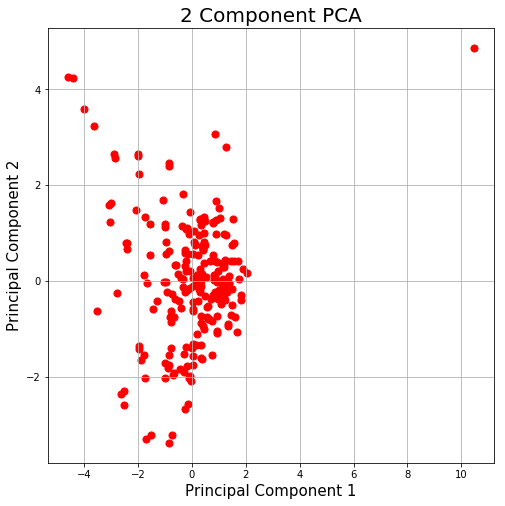

In [15]:
# we can now visualize the data by plotting them

# finalDf is the final DataFrame before plotting the data (nothing great, just taking result of PCA and attaching target to it)
#finalDf = pd.concat([principalDf, df[['target']]], axis = 1)

finalDf = principalDf # we don't have targets to show

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

ax.scatter(finalDf.loc[:, 'principal component 1']
          , finalDf.loc[:,'principal component 2']
          , c = 'r'
          , s = 50)

#targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
#colors = ['r', 'g', 'b']
#for target, color in zip(targets, colors):
#    indicesToKeep = finalDf['target'] == target
#    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
#               , finalDf.loc[indicesToKeep, 'principal component 2']
#               , c = color
#               , s = 50)
#ax.legend(targets)
ax.grid()
print("Number of points shown ", len(finalDf))



## Visualizing Data interactively with Plotly

In [9]:
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.tools as tls
import plotly.graph_objs as go

tls.set_credentials_file(username='D4nt3', api_key='FdMB4O6qCfciGDOnLvdQ')

In [22]:
# we'll draw a scatter graph with labels
traces = []
# let's get the labels
titles = [dictionary[TITLE_FIELD_NAME] for i, dictionary in enumerate(json_data) if i<TRAIN_DATA_LENGTH]
# double check to be sure we got labels just right
#i = 50
#print("TITLE: {0}\n <<{1}>>".format(titles[i], train_corpus[i][:1]))


for i in range(len(finalDf)):
    trace0 = go.Scatter(
        x = finalDf.loc[i:i, "principal component 1"],
        y = finalDf.loc[i:i, "principal component 2"],
        mode = 'markers',
        #name = 'blue markers',
        marker = dict(
            size = 7,
            color = 'rgba(0, 0, 110, .8)',
        ),
        text = str(titles[i])
    )
    traces.append(trace0)

data = traces 
layout = dict(title = 'PCA Representantion of DocVectors',
        hovermode= 'closest',
        xaxis= dict(
            title= 'first component',
            ticklen= 5,
            gridwidth= 2,
        ),
        yaxis=dict(
            title= 'second component',
            ticklen= 5,
            gridwidth= 2,
        ),
        showlegend = False
    )
# Plot and embed in ipython notebook!
fig = dict(data = data, layout = layout)
py.iplot(fig, filename='TA_model-scatter')

TITLE: Samsung lancia il suo primo smartphone con tre fotocamere - La Stampa
 <<(['samsung', 'lancia', 'il', 'suo', 'primo', 'smartphone', 'con', 'tre', 'fotocamere', 'la', 'stampail', 'mese', 'prossimo', 'samsung', 'lancerà', 'sul', 'mercato', 'il', 'galaxy', 'primo', 'smartphone', 'della', 'casa', 'coreana', 'essere', 'dotato', 'di', 'tre', 'fotocamere', 'posteriori', 'immagine', 'prodotta', 'dal', 'lavoro', 'simultaneo', 'dei', 'sensori', 'consentirà', 'di', 'ricreare', 'effetto', 'bokeh', 'nel', 'quale', 'possibile', 'mettere', 'fuoco', 'un', 'oggetto', 'sfocando', 'sensibilmente', 'ciò', 'che', 'gli', 'sta', 'dietro', 'davanti', 'non', 'un', 'cinquanta', 'millimetri', 'obbiettivo', 'molto', 'apprezzato', 'in', 'fotografia', 'proprio', 'perché', 'consente', 'di', 'sfocare', 'selettivamente', 'un', 'livello', 'dell', 'immagine', 'ma', 'ci', 'prova', 'il', 'galaxy', 'sarà', 'dotato', 'di', 'una', 'lente', 'da', 'megapixel', 'grandangolare', 'una', 'da', 'megapixel', 'ultima', 'dedica